**MODELO PREDICTIVO PARA LLAMADAS DEL CALL CENTER**


In [2]:
import numpy as np                               # vectores y matrices
import pandas as pd                              # tablas y data manipulations
import matplotlib.pyplot as plt                  # plots
from matplotlib.pylab import rcParams
import seaborn as sns                            # mas plots
sns.set()

from dateutil.relativedelta import relativedelta # trabajar con fechas
from scipy.optimize import minimize              
import datetime

import statsmodels.formula.api as smf            # statistics y econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # algunas funciones utiles
from tqdm import tqdm_notebook

import warnings                                  # quitar warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

rcParams['figure.figsize'] = 10, 6

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive
import os
print(os.getcwd())

Mounted at /content/gdrive
/content


**Se cargan los datos para el modelo**

trafico: Llamadas diarias del mes de septiembre

consolidado: Llamadas de los ultimos 6 meses del año 2021

In [4]:
trafico = pd.read_csv('/content/gdrive/MyDrive/Data_Science/SERIES_DE_TIEMPO/trafico.csv', index_col=['Fecha'], 
                  parse_dates=['Fecha'])
consolidado = pd.read_csv('/content/gdrive/MyDrive/Data_Science/SERIES_DE_TIEMPO/consolidado.csv', index_col=['Fecha'], 
                       parse_dates=['Fecha'])

In [5]:
trafico.head()

,Entrantes
Fecha,
2021-09-01,58441
2021-09-02,53067
2021-09-03,52716
2021-09-04,35878
2021-09-05,18776


In [6]:
trafico.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2021-09-01 to 2021-09-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Entrantes  30 non-null     int64
dtypes: int64(1)
memory usage: 480.0 bytes


In [7]:
consolidado.head()

,Entrantes
Fecha,
2021-04-01,32732
2021-04-02,20605
2021-04-03,42052
2021-04-04,25494
2021-04-05,77866


In [8]:
consolidado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2021-04-01 to 2021-09-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Entrantes  183 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


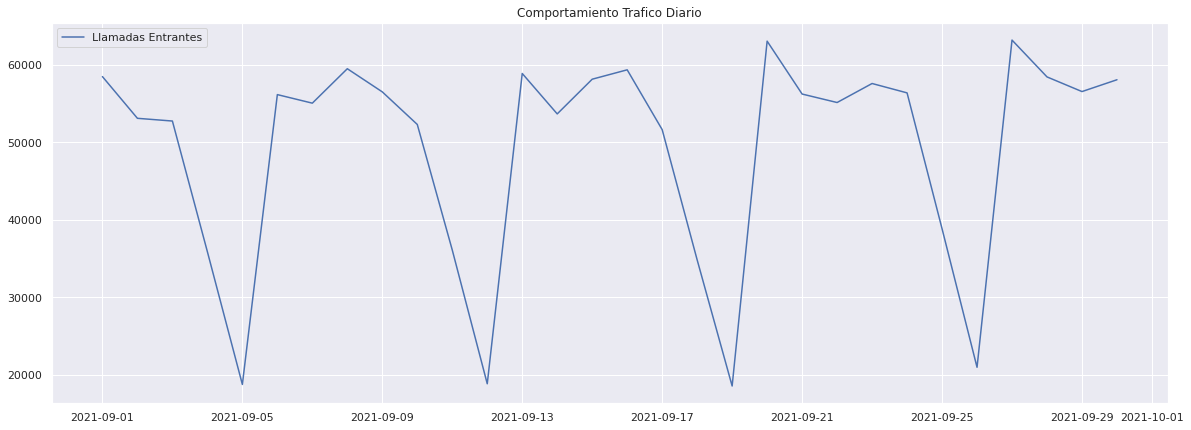

In [9]:
plt.figure(figsize=(20, 7))
plt.title('Comportamiento Trafico Diario')
plt.grid(True)
plt.plot(trafico['Entrantes'],label='Llamadas Entrantes')
plt.legend(loc=2)
plt.show()

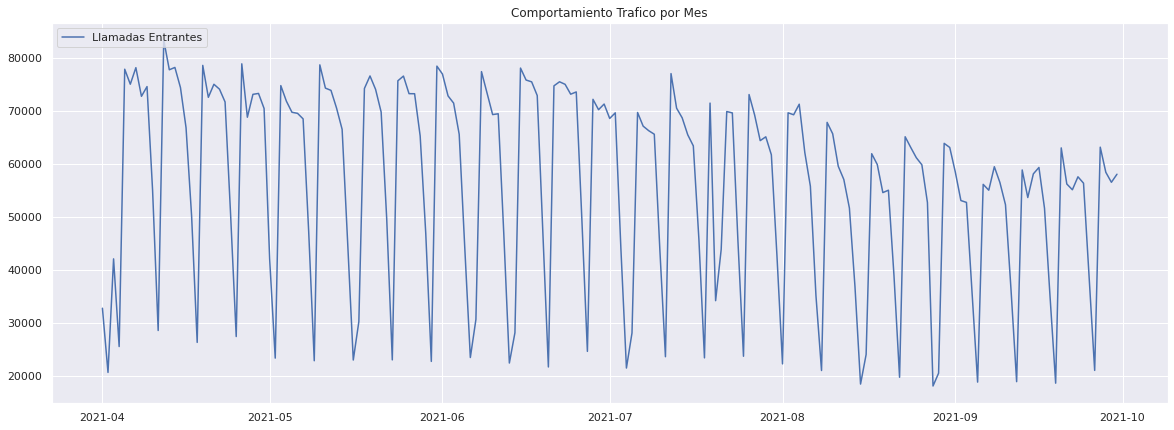

In [10]:
plt.figure(figsize=(20, 7))
plt.title('Comportamiento Trafico por Mes')
plt.grid(True)
plt.plot(consolidado['Entrantes'],label='Llamadas Entrantes')
plt.legend(loc=2)
plt.show()

**Suavizamiento**

In [11]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])
moving_average(consolidado, 4) 

59024.25

**Funcion para cuantificar la diferencia entre una predicción respecto a un valor real**

In [12]:
def mean_absolute_error(prediction,true_values):
    return np.mean(                                                      # Mean
                np.abs(                                                   # Absolute
                        prediction-true_values                            # Error
                      )
                  )

In [13]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - dataframe con la timeseries
        window - rolling window size
        plot_intervals - mostrar los intervalos de confianza
        plot_anomalies - Mostrar anomalias
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,7))
    plt.title("Media movil\n Window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Tendencia Media Movil ")

    # Graficar los intervaloes de confianza para valores smoothedes
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Con los intervaloes encontrar valores anormales 
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Valores actuales")
    plt.legend(loc="upper rihg")
    plt.grid(True)

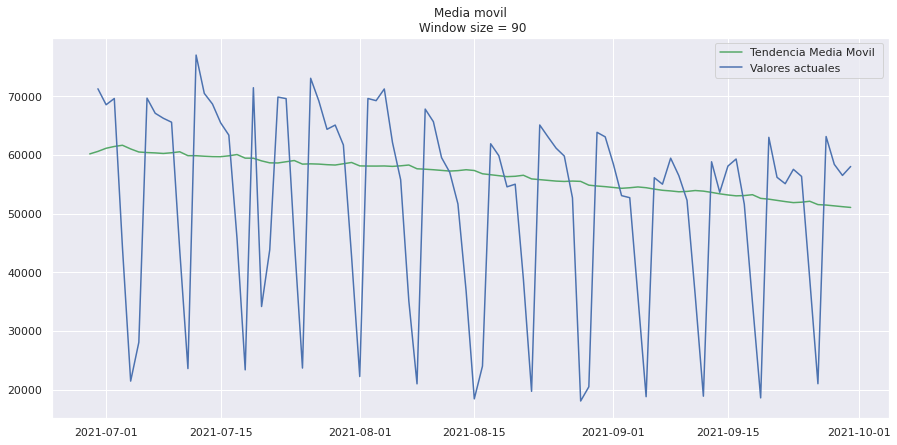

In [14]:
 plotMovingAverage(consolidado, 90)

In [15]:
def mean_absolute_percentage_error(prediction,true_values):
    return np.mean(                                                      # Mean
                np.abs(                                                   # Absolute
                        prediction-true_values                            # Error
                    )/true_values
                )

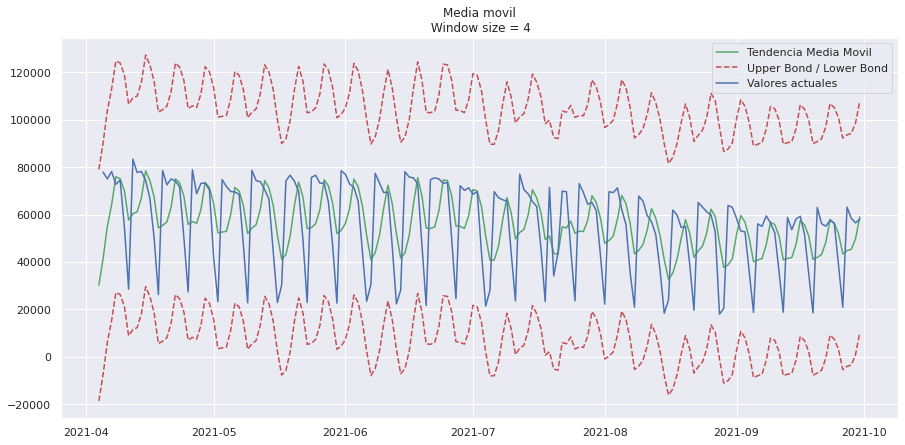

In [16]:
plotMovingAverage(consolidado, 4, plot_intervals=True)

**Detección de Anomalias**

In [17]:
consolidado_anomaly = consolidado.copy()
consolidado_anomaly.iloc[-10] = consolidado_anomaly.iloc[-10] * 0.1

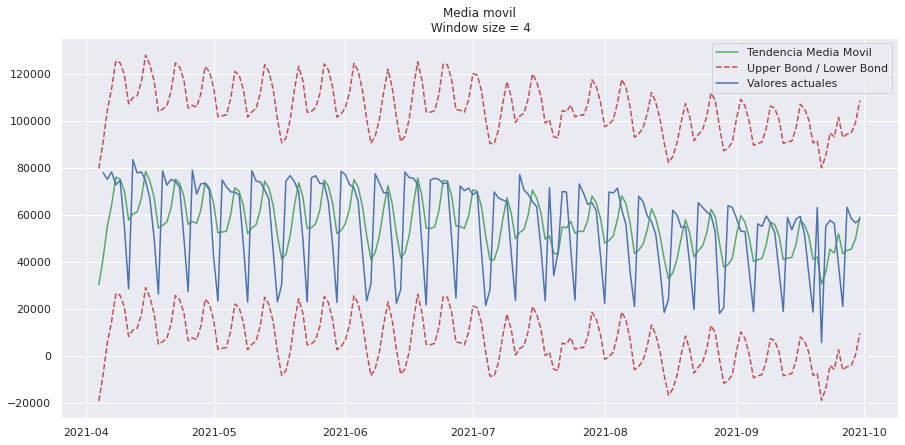

In [18]:
plotMovingAverage(consolidado_anomaly, 4, plot_intervals=True, plot_anomalies=True)

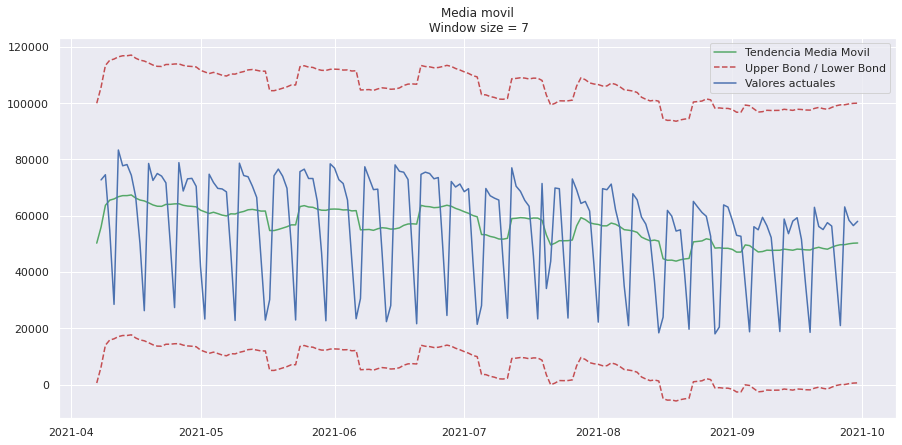

In [19]:
plotMovingAverage(consolidado, 7, plot_intervals=True, 
                  plot_anomalies=True) # suavizamiento semanal

**Estacionariedad**

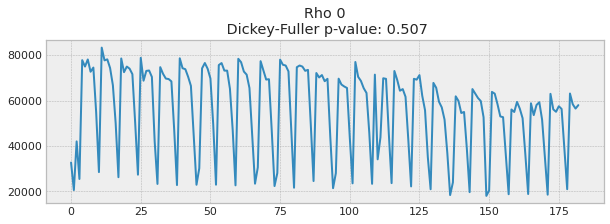

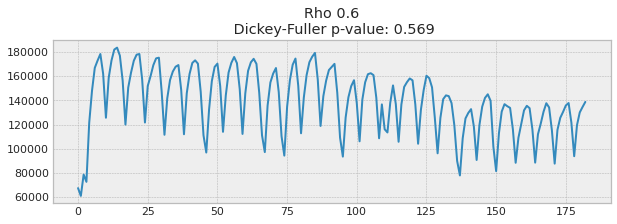

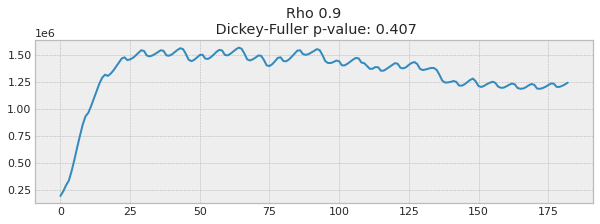

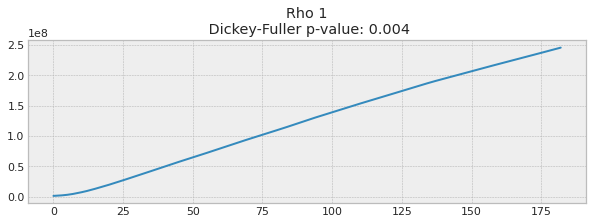

In [43]:
def plotProcess(x,rho=0):
    w = x 
    for t in range(len(x)):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3))) 
x = consolidado.copy()

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(x.Entrantes.values,rho=rho)

In [44]:
X = x.Entrantes.values
result = sm.tsa.stattools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.734019
p-value: 0.003659
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


In [45]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Grafica la serie de tiempo, la ACF y PACF, calcula la prueba de Dickey–Fuller 
        
        y - timeseries
        lags - cuantos lags queremos incluir en la ACF, PACF 
    """
           
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

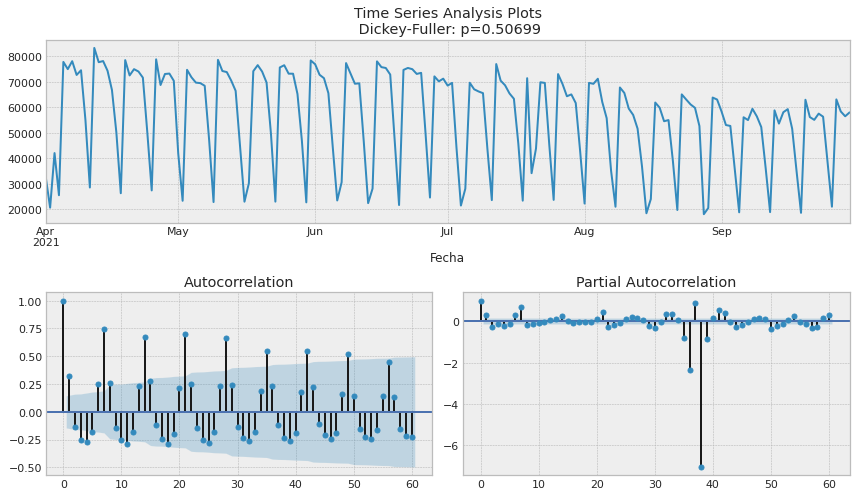

In [46]:
tsplot(consolidado.Entrantes, lags=60)

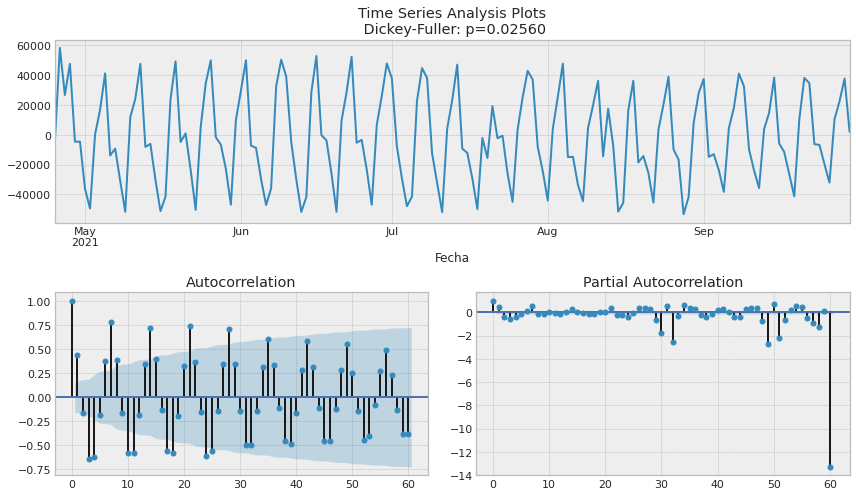

In [47]:
consolidado_diff = consolidado.Entrantes - consolidado.Entrantes.shift(24)
tsplot(consolidado_diff[24:], lags=60)

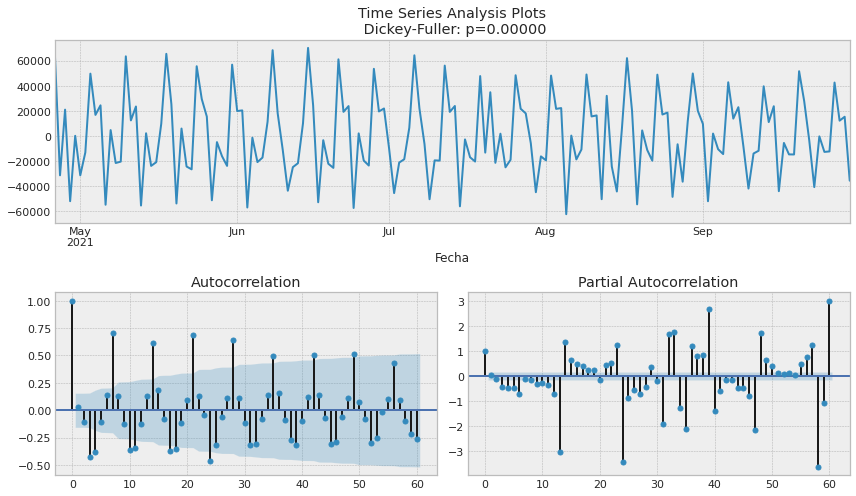

In [48]:
consolidado_diff = consolidado_diff - consolidado_diff.shift(1)
tsplot(consolidado_diff[24+1:], lags=60)

In [1]:
tsplot(consolidado_diff[168+1:], lags=60)

NameError: ignored

In [50]:
# Definir valores iniciales 
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creando lista de posibles combinaciones 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
len(parameters_list)

[(2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1), (2, 3, 0, 0), (2, 3, 0, 1), (2, 3, 1, 0), (2, 3, 1, 1), (2, 4, 0, 0), (2, 4, 0, 1), (2, 4, 1, 0), (2, 4, 1, 1), (3, 2, 0, 0), (3, 2, 0, 1), (3, 2, 1, 0), (3, 2, 1, 1), (3, 3, 0, 0), (3, 3, 0, 1), (3, 3, 1, 0), (3, 3, 1, 1), (3, 4, 0, 0), (3, 4, 0, 1), (3, 4, 1, 0), (3, 4, 1, 1), (4, 2, 0, 0), (4, 2, 0, 1), (4, 2, 1, 0), (4, 2, 1, 1), (4, 3, 0, 0), (4, 3, 0, 1), (4, 3, 1, 0), (4, 3, 1, 1), (4, 4, 0, 0), (4, 4, 0, 1), (4, 4, 1, 0), (4, 4, 1, 1)]


36

Usamos el Metodo Autoregressive Integrated Moving Average (ARIMA) para hacer predicciones de series de tiempo

In [51]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Devuelve un dataframe con parametros y correspondientes valores de AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # Tenemos que hacer un try-except porque algunas combinaciones fallan en converger
        try:
            model=sm.tsa.statespace.SARIMAX(consolidado.Entrantes, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # guardar el mejor modelo, AIC y parametros
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Ordener de manera creciente, a menor valor de AIC es MEJOR
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [52]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 7min 29s, sys: 5min 19s, total: 12min 49s
Wall time: 6min 31s


In [53]:
result_table.head(10)

,parameters,aic
0,"(4, 3, 0, 1)",3552.871670
1,"(4, 4, 0, 1)",3559.301325
2,"(4, 4, 1, 1)",3560.644696
3,"(4, 4, 1, 0)",3566.818764
4,"(3, 2, 0, 1)",3568.574685
5,"(3, 4, 0, 1)",3569.645226
6,"(3, 4, 1, 1)",3571.284750
7,"(3, 3, 0, 1)",3574.902101
8,"(4, 3, 1, 1)",3575.972594
9,"(3, 3, 1, 1)",3576.510831


In [54]:
# Ajustar los parametros para dejar el valor mas bajo de AIC
d=1
D=1
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(consolidado.Entrantes, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Entrantes   No. Observations:                  183
Model:             SARIMAX(4, 1, 3)x(0, 1, 1, 24)   Log Likelihood               -1767.436
Date:                            Sat, 23 Oct 2021   AIC                           3552.872
Time:                                    14:36:35   BIC                           3580.435
Sample:                                04-01-2021   HQIC                          3564.065
                                     - 09-30-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9065      0.251      3.610      0.000       0.414       1.399
ar.L2         -0.9946      0.257   

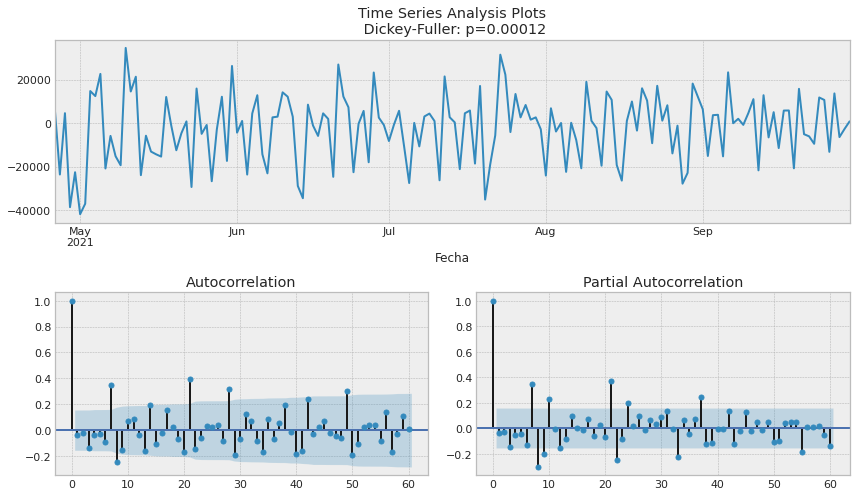

In [55]:
tsplot(best_model.resid[24+1:], lags=60)

**Prediccion usando el modelo**

In [56]:
def plotSARIMA(series, model, n_steps):
    """
        Plots del modelo vs valores predichos
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # Adicionar los valores del modelo
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # hacer un cambio en los pasos s + d, porque estos valores no fueron observados por el modelo
     # debido a la diferenciación
    data['arima_model'][:s+d] = np.NaN
    
    # pronosticando n_pasos adelante    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calcular el error, nuevamente habiendo cambiado en los pasos s + d desde el principio
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Error: {0:.2f}%".format(error*100))# 
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

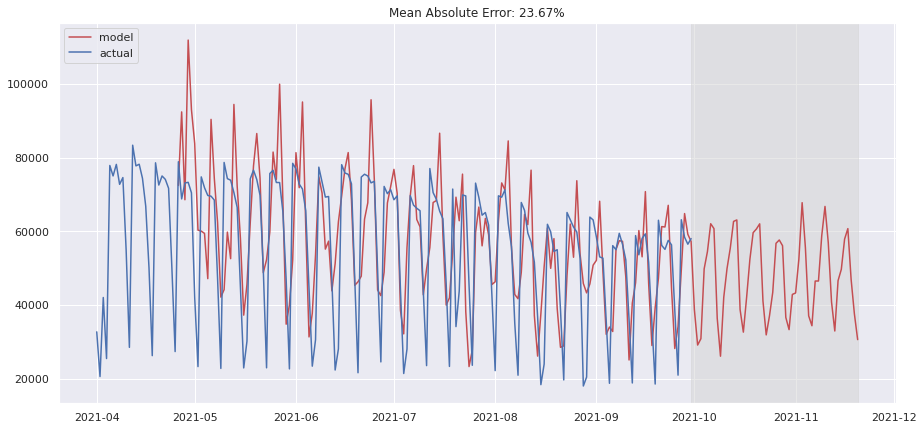

In [57]:
plotSARIMA(consolidado, best_model, 50)

In [113]:
best_model